# file loading

In [1]:
import requests
import zipfile
import io

# 구글 드라이브 공유 링크에서 파일 ID를 가져옵니다.
file_id = '1ZUueEhjvhzmo8UpZLwqMgzMKA6FGtLJk'  # 여기에 파일 ID를 입력하세요.
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# 파일 다운로드
response = requests.get(download_url)
response.raise_for_status()  # 요청이 실패하면 예외를 발생시킵니다.

# 다운로드한 ZIP 파일을 메모리에서 직접 압축 해제합니다.
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall('/content/unzipped_folder')

# 결과 확인
import os
os.listdir('/content/unzipped_folder')


['sample_submission.csv', 'test.csv', 'train.csv']

# data loading

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [3]:
# 데이터 불러오기
df = pd.read_csv("/content/unzipped_folder/train.csv")
train = pd.read_csv("/content/unzipped_folder/train.csv")
test = pd.read_csv("/content/unzipped_folder/test.csv")

# heatmap

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

# Cramér's V 계산 함수
def cramers_v(confusion_matrix):
    try:
        chi2, p, dof, expected = chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        r, k = confusion_matrix.shape
        return np.sqrt(chi2 / (n * (min(r, k) - 1)))
    except Exception as e:
        print(f"Error calculating Cramér's V: {e}")
        return np.nan  # Return NaN in case of error

# 데이터프레임이 df라고 가정
df_features = df.drop(columns=['ID', 'SUBCLASS'])
df_target = df['SUBCLASS']

# Cramér's V 값이 0.3 이상인 피처만 저장할 딕셔너리 생성
significant_cramersv_dict = {}
# 오류가 발생한 피처를 저장할 리스트
error_features = []

# 각 열에 대해 Cramér's V 계산
for col in df_features.columns:
    # 교차표 생성
    confusion_matrix = pd.crosstab(df_target, df_features[col])

    # Cramér's V 값 계산
    cramers_v_value = cramers_v(confusion_matrix)

    # NaN 값 처리 및 오류 기록
    if pd.isna(cramers_v_value):
        error_features.append(col)
    else:
        if cramers_v_value >= 0.2:
            significant_cramersv_dict[col] = cramers_v_value

# Cramér's V 값을 DataFrame으로 변환
significant_features_df = pd.DataFrame.from_dict(significant_cramersv_dict, orient='index', columns=['Cramér’s V'])
# 오류 목록을 DataFrame으로 변환
error_features_df = pd.DataFrame(error_features, columns=['Feature'])

# CSV 파일로 저장
significant_features_df.to_csv('significant_features.csv', index=True)
error_features_df.to_csv('error_features.csv', index=False)


<ipython-input-12-b1232b198a4a>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-12-b1232b198a4a>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-12-b1232b198a4a>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-12-b1232b198a4a>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-12-b1232b198a4a>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-12-b1232b198a4a>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-12-b1232b198a4a>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-12-b1232b198a4a>:13: RuntimeWarning: inv

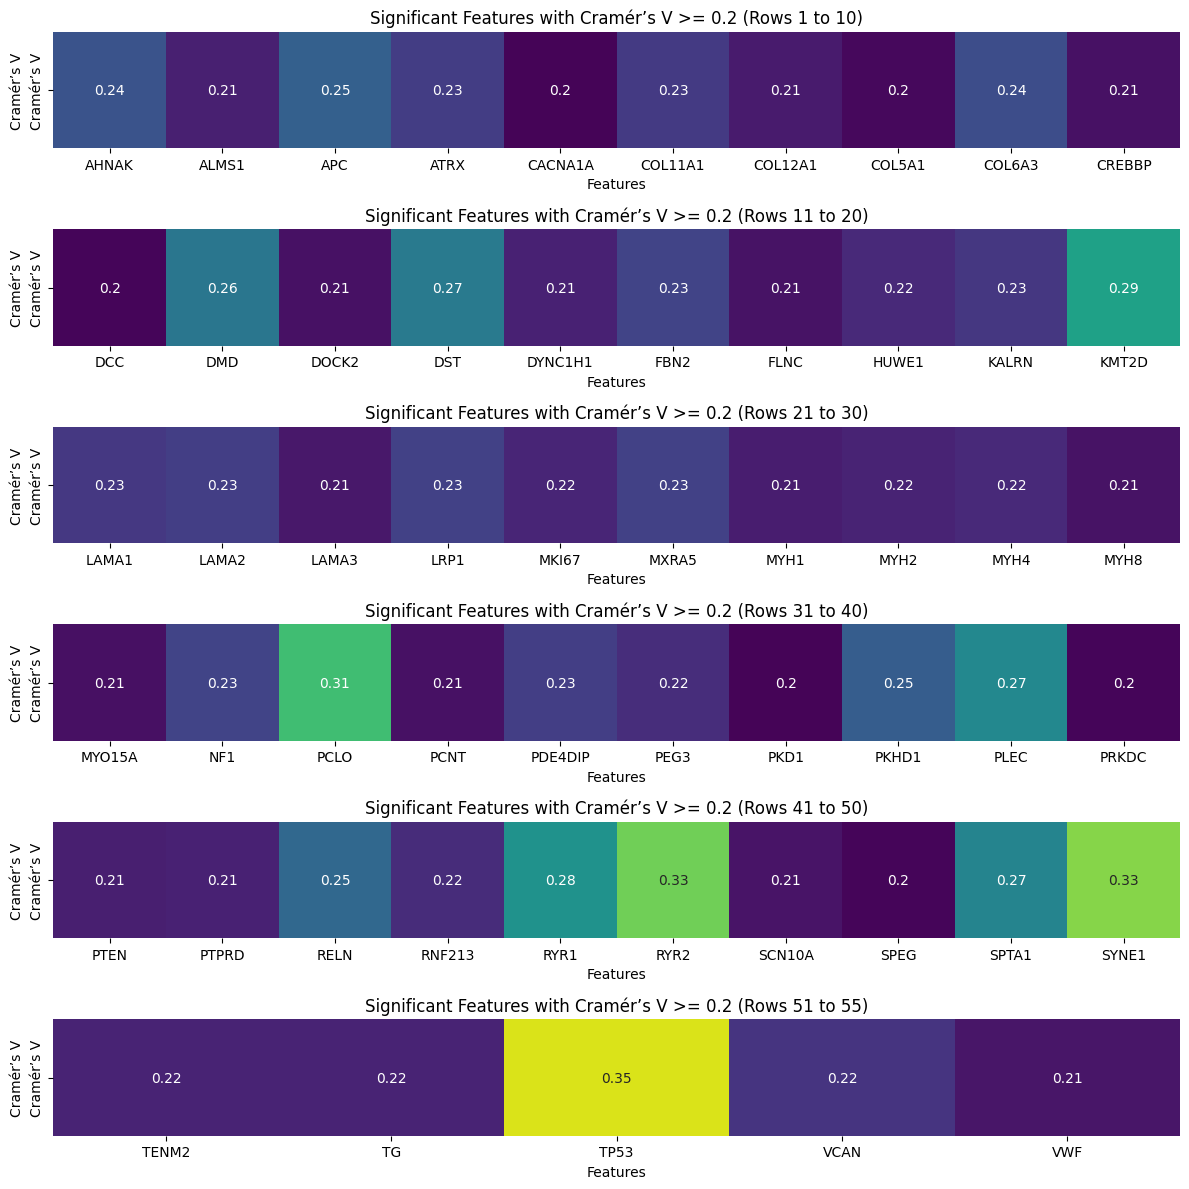

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Cramér's V 값이 0.1 ~ 0.4 사이로 색상 범위를 조정
cmap = sns.color_palette("viridis", as_cmap=True)
norm = plt.Normalize(vmin=0.2, vmax=0.36)


# 필터링된 피처의 Cramér's V 값을 한 줄에 50개씩 나누어 시각화
if not significant_features_df.empty:
    # 데이터프레임을 50개씩 나누어 리스트로 변환
    num_features_per_row = 10
    num_rows = int(np.ceil(len(significant_features_df) / num_features_per_row))

    plt.figure(figsize=(12, num_rows * 2))  # 높이는 필터링된 피처의 수에 따라 조절

    for i in range(num_rows):
        start_idx = i * num_features_per_row
        end_idx = min((i + 1) * num_features_per_row, len(significant_features_df))

        # 데이터 슬라이스
        subset_df = significant_features_df.iloc[start_idx:end_idx]

        # 각 슬라이스에 대한 heatmap 그리기
        plt.subplot(num_rows, 1, i + 1)
        sns.heatmap(subset_df.T, annot=True, cmap='viridis', norm=norm, vmin=0, vmax=1, cbar=False)
        plt.title(f'Significant Features with Cramér’s V >= 0.2 (Rows {start_idx+1} to {end_idx})')
        plt.xlabel('Features')
        plt.ylabel('Cramér’s V')

    plt.tight_layout()
    plt.show()
else:
    print("No features with Cramér’s V >= 0.2 found.")


# encoding

In [20]:
import requests
import pandas as pd
import io

"""
https://drive.google.com/file/d/1p5Kk49mm6e3hXqnHDfI4DV8OC-rvEjqz/view?usp=sharing
https://drive.google.com/file/d/1p5Kk49mm6e3hXqnHDfI4DV8OC-rvEjqz/view?usp=sharing
https://drive.google.com/file/d/1gpaS9u8BFsiHbw8NL_OX3jpxV4LOGGQq/view?usp=sharing
https://drive.google.com/file/d/1FT4Pl7rhmF874bLZ_toY80NyO_YH5soJ/view?usp=sharing
"""

# 구글 드라이브 공유 링크에서 파일 ID를 가져옵니다.
file_id = '1p5Kk49mm6e3hXqnHDfI4DV8OC-rvEjqz'  # 여기에 파일 ID를 입력하세요.
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# 파일 다운로드
response = requests.get(download_url)
response.raise_for_status()  # 요청이 실패하면 예외를 발생시킵니다.

# 다운로드한 CSV 파일을 메모리에서 직접 읽어 DataFrame으로 변환합니다.
csv_file = io.StringIO(response.text)
df1 = pd.read_csv(csv_file)

print("shape1: ", df1.shape)

shape1:  (1219, 2)


In [21]:
# 구글 드라이브 공유 링크에서 파일 ID를 가져옵니다.
file_id = '1gpaS9u8BFsiHbw8NL_OX3jpxV4LOGGQq'  # 여기에 파일 ID를 입력하세요.
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# 파일 다운로드
response = requests.get(download_url)
response.raise_for_status()  # 요청이 실패하면 예외를 발생시킵니다.

# 다운로드한 CSV 파일을 메모리에서 직접 읽어 DataFrame으로 변환합니다.
csv_file = io.StringIO(response.text)
df2 = pd.read_csv(csv_file)

print("shape2: ", df2.shape)

shape2:  (55, 2)


In [22]:
# 구글 드라이브 공유 링크에서 파일 ID를 가져옵니다.
file_id = '1FT4Pl7rhmF874bLZ_toY80NyO_YH5soJ'  # 여기에 파일 ID를 입력하세요.
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# 파일 다운로드
response = requests.get(download_url)
response.raise_for_status()  # 요청이 실패하면 예외를 발생시킵니다.

# 다운로드한 CSV 파일을 메모리에서 직접 읽어 DataFrame으로 변환합니다.
csv_file = io.StringIO(response.text)
df3 = pd.read_csv(csv_file)

print("shape3: ", df3.shape)

shape3:  (4, 2)


In [23]:
gene1 = df1.iloc[:, 0].tolist()
gene2 = df2.iloc[:, 0].tolist()
gene3 = df3.iloc[:, 0].tolist()
print(len(gene1), len(gene2), len(gene3))

1219 55 4


In [70]:
# gene1 리스트에 있는 문자열과 일치하는 열만 선택
selected_columns = [col for col in df.columns if col in gene2]

# 독립 변수와 종속 변수 설정
X = df[selected_columns]
y = df['SUBCLASS']

new_df = pd.concat([X, y], axis=1)

### 레이블 인코딩

In [71]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코딩
le = LabelEncoder()

# 각 열을 레이블 인코딩
X_encoded = X.apply(lambda col: le.fit_transform(col))

### 원 핫 인코딩

In [46]:
# 범주형 변수를 원-핫 인코딩
X_encoded = pd.get_dummies(X)

### 빈도 인코딩

In [51]:
import pandas as pd

for column in X.columns:
    # 빈도수 계산
    freq = df[column].value_counts()

    # 빈도 인코딩 적용
    df.loc[:, column] = df[column].map(freq)


### 타겟 인코딩

In [58]:
# X와 타겟 변수 설정 (X는 범주형 피처를 포함하고 있다고 가정)
df_target = new_df['SUBCLASS']  # 타겟 변수
df_features = X.copy()  # 피처 변수 (X)

# 타겟 변수의 범주를 숫자로 변환
df_target_numeric = df_target.astype('category').cat.codes

# 타겟 인코딩을 수행하여 새로운 데이터프레임 생성
X_encoded = df_features.copy()  # X의 복사본을 생성하여 인코딩 결과를 저장할 데이터프레임

for feature in df_features.columns:
    # 각 피처의 고유값에 대한 타겟 변수 평균 계산
    mean_target = df_target_numeric.groupby(df_features[feature]).mean()

    # 피처를 타겟 변수의 비율로 인코딩하고 새로운 열에 저장
    X_encoded[feature] = df_features[feature].map(mean_target)

### 바이너리 인코딩

In [63]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.0 MB/s eta 0:00:00


In [65]:
import category_encoders as ce

# BinaryEncoder 객체 생성
encoder = ce.BinaryEncoder(cols=X.select_dtypes(include=['object']).columns)

# X에 대해 인코딩 수행
X_encoded = encoder.fit_transform(X)


## 학습

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# 예측 및 결과 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 변수 중요도 출력
importance = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': model.feature_importances_})
importance = importance.sort_values(by='Importance', ascending=False)

# 중요 변수 필터링
threshold = 0.1  # 기준 설정
important_features = importance[importance['Importance'] > threshold]

if important_features.empty:
    print("중요한 변수가 없습니다. 기준 값을 낮춰보세요.")
else:
    print("중요한 변수들:")
    print(important_features)


              precision    recall  f1-score   support

         ACC       0.10      0.21      0.14        14
        BLCA       0.11      0.04      0.06        27
        BRCA       0.04      0.01      0.02       149
        CESC       0.10      0.10      0.10        31
        COAD       0.50      0.53      0.52        30
        DLBC       0.13      0.40      0.20        10
      GBMLGG       0.20      0.09      0.12       116
        HNSC       0.17      0.10      0.12        51
       KIPAN       0.08      0.05      0.06        86
        KIRC       0.09      0.07      0.08        54
        LAML       0.08      0.69      0.14        39
         LGG       0.09      0.08      0.09        49
        LIHC       0.00      0.00      0.00        34
        LUAD       0.15      0.11      0.12        37
        LUSC       0.35      0.15      0.21        39
          OV       0.22      0.24      0.23        58
        PAAD       0.03      0.04      0.04        24
        PCPG       0.16    